In [19]:
import pandas as pd
import numpy as np
pd.options.mode.copy_on_write = True

In [20]:
df = pd.read_csv('customer.csv')

In [3]:
print("Seeing the first 10 lines of the data set \n")
print(df.head(10))
print('\n')
print("Counting the missing values in each collumn \n")
print(df.isnull().sum())
print('\n')
print("Data set info \n")
print(df.info())
print("\n")
print("Describe data \n")
print(df.describe())
print("\n")
print("Número de registros:", len(df))
print("Número de colunas:", len(df.columns))

Seeing the first 10 lines of the data set 

   Unnamed: 0        custid     sex is_employed   income      marital_status  \
0           7  000006646_03    Male        True  22000.0       Never married   
1           8  000007827_01  Female         NaN  23200.0  Divorced/Separated   
2           9  000008359_04  Female        True  21000.0       Never married   
3          10  000008529_01  Female         NaN  37770.0             Widowed   
4          11  000008744_02    Male        True  39000.0  Divorced/Separated   
5          15  000011466_01    Male         NaN  11100.0             Married   
6          17  000015018_01  Female        True  25800.0             Married   
7          19  000017314_02  Female         NaN  34600.0             Married   
8          20  000017383_04  Female        True  25000.0       Never married   
9          21  000017554_02    Male        True  31200.0             Married   

   health_ins                  housing_type  num_vehicles  age state_of_res

In [4]:
#1686/72458 -> 2%

df[df["housing_type"].isnull() == True]

# We took out all the lines that had Nan because they were the same in those 3 columns
df = df.dropna(subset=["housing_type"])
df[df["housing_type"].isnull() == True]

# There was still one missing value in the collumn recent_move_b so we replaced it with the mode
df[df["recent_move_b"].isnull() == True]
mode = df["recent_move_b"].mode()[0]
df["recent_move_b"] = df["recent_move_b"].fillna(mode)

In [5]:
for col in df.columns:
    print(col)
    print(pd.unique(df[col]))
    print(len(pd.unique(df[col])))
    print("\n")

Unnamed: 0
[    7     8     9 ... 99997 99998 99999]
70772


custid
['000006646_03' '000007827_01' '000008359_04' ... '001507219_01'
 '001513103_01' '001519624_01']
70772


sex
['Male' 'Female']
2


is_employed
[True nan False]
3


income
[22000. 23200. 21000. ... 25110. 18010. 26850.]
4423


marital_status
['Never married' 'Divorced/Separated' 'Widowed' 'Married']
4


health_ins
[ True False]
2


housing_type
['Homeowner free and clear' 'Rented' 'Homeowner with mortgage/loan'
 'Occupied with no rent']
4


num_vehicles
[0. 2. 1. 5. 3. 4. 6.]
7


age
[ 24  82  31  93  67  76  26  73  27  54  61  64  55  65  33  47  68  46
  58  43  41  62  21  78  32  59  29  70  30  28  86  35  34  40  72  60
  25  79  22  42  44  81  50  45  63  57  39  71  38  49  69  37  66  53
  36  23  75  88  51  85  52  83  77  56  48 100  74  89  80  84   0  87
 120  91 110 114  94  90  96  92  95]
81


state_of_res
['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'Dist

### Exploratory Data Analysis

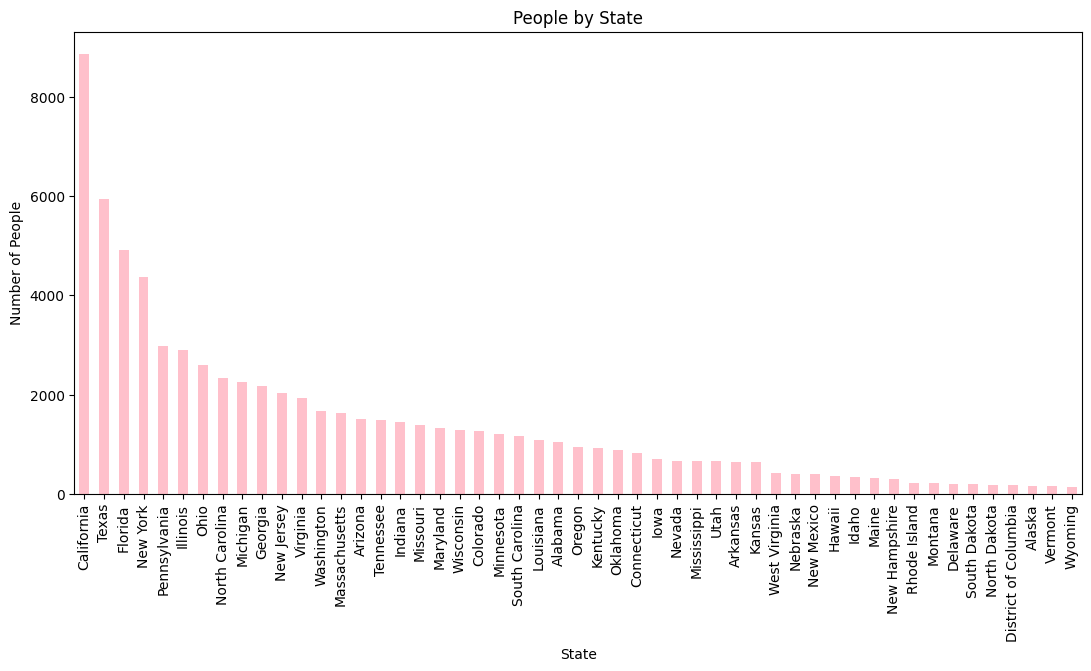

In [34]:
import matplotlib.pyplot as plt

# Where do they live?

state_counts = df['state_of_res'].value_counts()
plt.figure(figsize=(13, 6))
state_counts.plot(kind='bar', color='pink')
plt.title('People by State')
plt.xlabel('State')
plt.ylabel('Number of People')
plt.show()

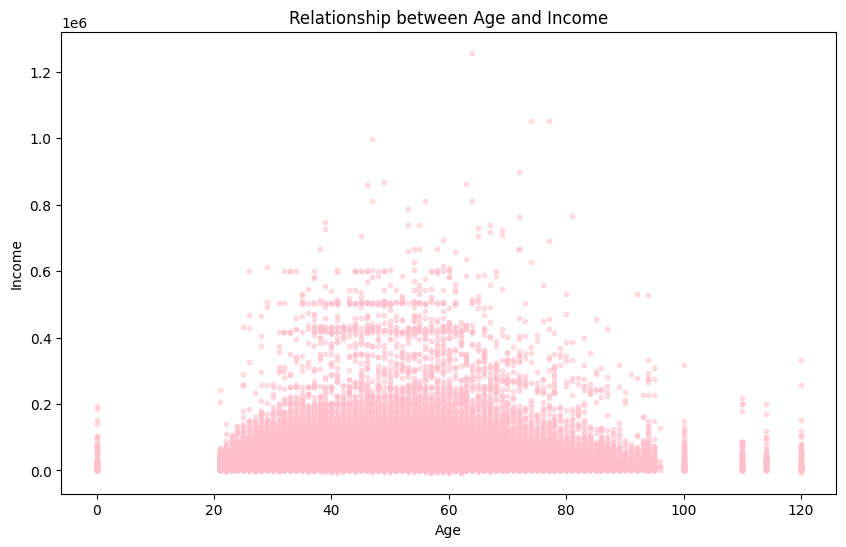

In [ ]:
# What is the relation between age and income?

plt.figure(figsize=(10, 6))
plt.scatter(df['age'], df['income'], alpha=0.5, s=10, color='pink')  
plt.title('Relationship between Age and Income')
plt.xlabel('Age')
plt.ylabel('Income')
plt.show()

(Como se pode ver no gráfico, há claros outliers na idade mas fora isso vemos que o income tem o seu peak na middle age (30-60) e mais baixos em pessoas mais velhas e mais novas que esse intervalo)

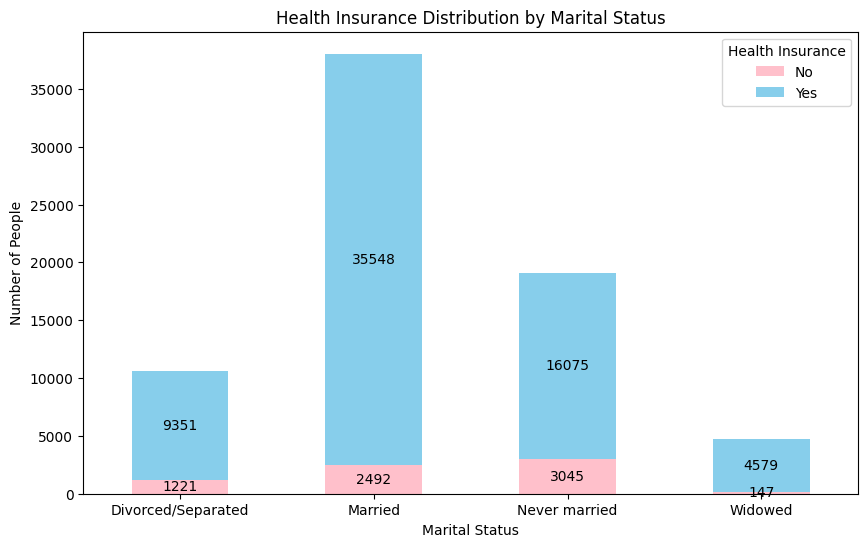

health_ins              False      True 
marital_status                          
Divorced/Separated  11.549376  88.450624
Married              6.550999  93.449001
Never married       15.925732  84.074268
Widowed              3.110453  96.889547


In [ ]:
#How the health insurance distributes according to the marital status?

health_counts = df.groupby(['marital_status', 'health_ins']).size().unstack()
ax = health_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['pink', 'skyblue'])

# Add labels to each bar segment
for container in ax.containers:
    ax.bar_label(container, label_type='center')  

# Customize plot
plt.title('Health Insurance Distribution by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Number of People')
plt.legend(title='Health Insurance', labels=['No', 'Yes'])  
plt.xticks(rotation=0)  
plt.show()

# Percentages

print(health_counts.div(health_counts.sum(axis=1), axis=0) * 100)

In [7]:
# EDA - Camila

In [8]:
# EDA - Bárbara

In [9]:
# Drop unnamed
df = df.drop(columns=['Unnamed: 0'])

# Drop custid and code_column
df = df.drop(columns=['custid', 'code_column'])
# code_column corresponds to state

# Sex
df = pd.get_dummies(df, columns=['sex'], drop_first=True)
df['sex_Male'] = df['sex_Male'].map({False: 0, True: 1})

# Is_employed
df['is_employed'] = df['is_employed'].map({False: "unemployed", True: "employed"})
df['is_employed'] = df['is_employed'].fillna("not_in_workforce")

# Health_ins
df['health_ins'] = df['health_ins'].map({False: 0, True: 1})

# Mudar o Número de veículos para type inteiro
df['num_vehicles'] = df['num_vehicles'].astype(int)

# Gas_usage 1 2 3 to zero and all to int
df['gas_usage'] = df['gas_usage'].astype(int)
df['gas_usage'] = df['gas_usage'].replace([1, 2, 3], 0)

# Recent_move_b
df['recent_move_b'] = df['recent_move_b'].map({'F': 0, 'T': 1})

# Marital status
df = pd.get_dummies(df, columns=['marital_status'], drop_first=True)
df = pd.get_dummies(df, columns=['housing_type'], drop_first=True)
df = pd.get_dummies(df, columns=['state_of_res'], drop_first=True)
df = pd.get_dummies(df, columns=['is_employed'], drop_first=True)

df.columns

Index(['income', 'health_ins', 'num_vehicles', 'age', 'gas_usage', 'rooms',
       'recent_move_b', 'sex_Male', 'marital_status_Married',
       'marital_status_Never married', 'marital_status_Widowed',
       'housing_type_Homeowner with mortgage/loan',
       'housing_type_Occupied with no rent', 'housing_type_Rented',
       'state_of_res_Alaska', 'state_of_res_Arizona', 'state_of_res_Arkansas',
       'state_of_res_California', 'state_of_res_Colorado',
       'state_of_res_Connecticut', 'state_of_res_Delaware',
       'state_of_res_District of Columbia', 'state_of_res_Florida',
       'state_of_res_Georgia', 'state_of_res_Hawaii', 'state_of_res_Idaho',
       'state_of_res_Illinois', 'state_of_res_Indiana', 'state_of_res_Iowa',
       'state_of_res_Kansas', 'state_of_res_Kentucky',
       'state_of_res_Louisiana', 'state_of_res_Maine', 'state_of_res_Maryland',
       'state_of_res_Massachusetts', 'state_of_res_Michigan',
       'state_of_res_Minnesota', 'state_of_res_Mississippi',


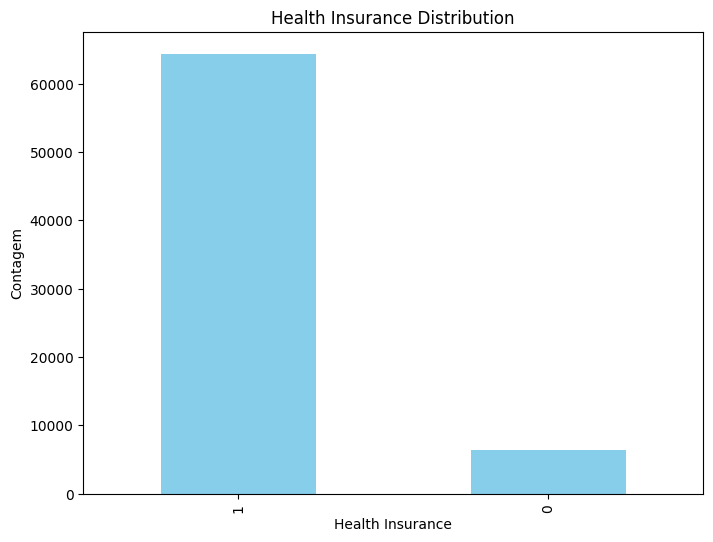

health_ins
1    64339
0     6433
Name: count, dtype: int64


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

health_ins_distribution = df['health_ins'].value_counts()

plt.figure(figsize=(8, 6))
health_ins_distribution.plot(kind='bar', color='skyblue')
plt.title('Health Insurance Distribution')
plt.xlabel('Health Insurance')
plt.ylabel('Contagem')
plt.show()

print(health_ins_distribution)

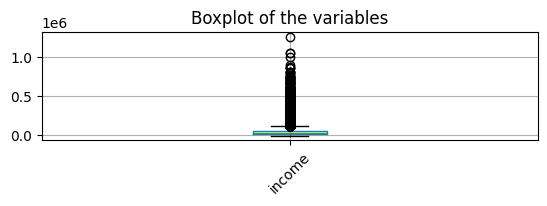

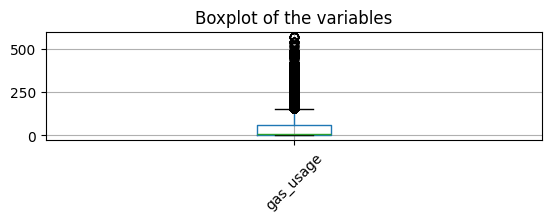

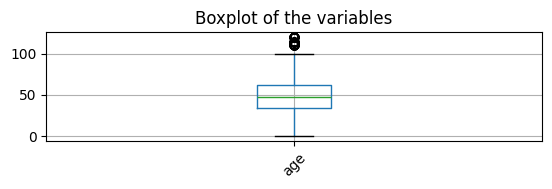

In [11]:
plt.subplot(3, 1, 1)
df2 = df[['income']]
df2.boxplot()
plt.title('Boxplot of the variables')
plt.xticks(rotation=45)
plt.show()

plt.subplot(3, 1, 2)
df2 = df[['gas_usage']]
df2.boxplot()
plt.title('Boxplot of the variables')
plt.xticks(rotation=45)
plt.show()

plt.subplot(3, 1, 3)
df2 = df[['age']]
df2.boxplot()
plt.title('Boxplot of the variables')
plt.xticks(rotation=45)
plt.show()

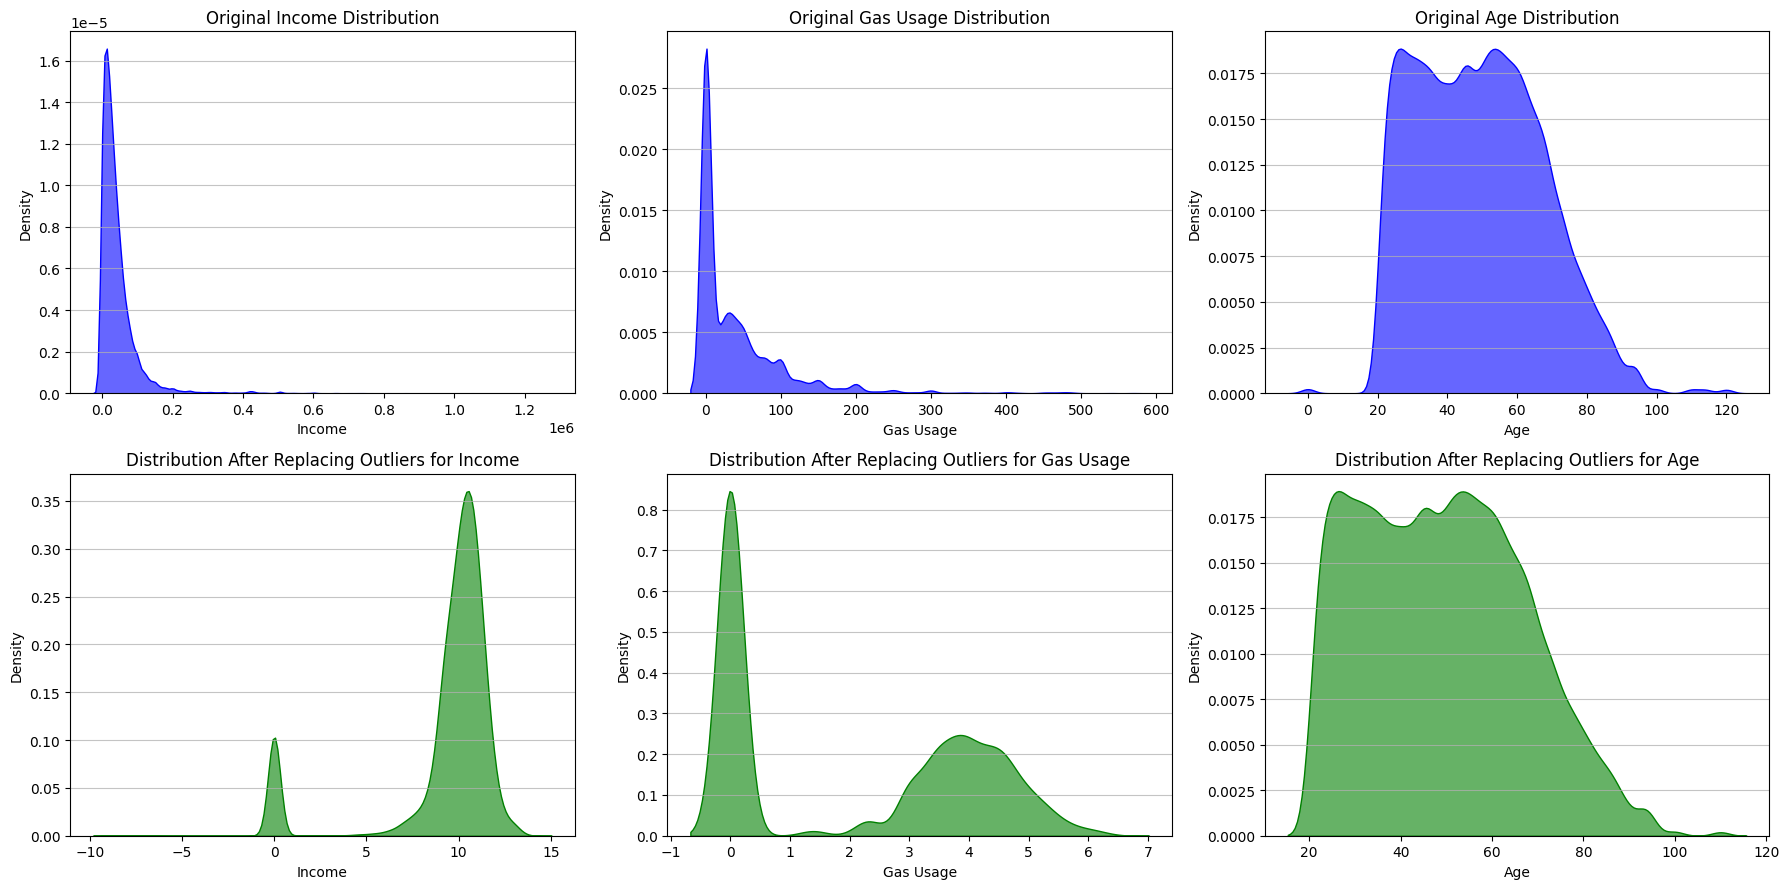

In [12]:
plt.figure(figsize=(18, 9))  

# Subplot 1: Original Income Distribution
plt.subplot(2, 3, 1)
sns.kdeplot(df['income'], fill=True, color='blue', alpha=0.6)
plt.title('Original Income Distribution')
plt.xlabel('Income')
plt.ylabel('Density')
plt.grid(axis='y', alpha=0.75)

# Subplot 2: Original Gas Usage Distribution
plt.subplot(2, 3, 2)
sns.kdeplot(df['gas_usage'], fill=True, color='blue', alpha=0.6)
plt.title('Original Gas Usage Distribution')
plt.xlabel('Gas Usage')
plt.ylabel('Density')
plt.grid(axis='y', alpha=0.75)

# Subplot 3: Original Age Distribution
plt.subplot(2, 3, 3)
sns.kdeplot(df['age'], fill=True, color='blue', alpha=0.6)
plt.title('Original Age Distribution')
plt.xlabel('Age')
plt.ylabel('Density')
plt.grid(axis='y', alpha=0.75)

# Replace outliers for income, age, and gas usage
df['income'] = df['income'].apply(
    lambda x: np.log(x) if x > 0 else (-np.log(abs(x)) if x < 0 else 0)
)
#df['income'] = df['income'].where(df['income'] <= 0.1 * 10**6, 0.1 * 10**6)
df = df[(df['age'] != 0) & (df['age'] <= 110)]
df['gas_usage'] = df['gas_usage'].apply(lambda x: np.log(x) if x > 0 else 0)

# Subplot 4: Distribution After Replacing Outliers for Income
plt.subplot(2, 3, 4)
sns.kdeplot(df['income'], fill=True, color='green', alpha=0.6)
plt.title('Distribution After Replacing Outliers for Income')
plt.xlabel('Income')
plt.ylabel('Density')
plt.grid(axis='y', alpha=0.75)

# Subplot 5: Distribution After Replacing Outliers for Gas Usage
plt.subplot(2, 3, 5)
sns.kdeplot(df['gas_usage'], fill=True, color='green', alpha=0.6)
plt.title('Distribution After Replacing Outliers for Gas Usage')
plt.xlabel('Gas Usage')
plt.ylabel('Density')
plt.grid(axis='y', alpha=0.75)

# Subplot 4«6: Distribution After Replacing Outliers for Age
plt.subplot(2, 3, 6)
sns.kdeplot(df['age'], fill=True, color='green', alpha=0.6)
plt.title('Distribution After Replacing Outliers for Age')
plt.xlabel('Age')
plt.ylabel('Density')
plt.grid(axis='y', alpha=0.75)

plt.tight_layout()  
plt.show()


In [13]:
print(df[(df['age'] == 0) | (df['age'] > 110)])

Empty DataFrame
Columns: [income, health_ins, num_vehicles, age, gas_usage, rooms, recent_move_b, sex_Male, marital_status_Married, marital_status_Never married, marital_status_Widowed, housing_type_Homeowner with mortgage/loan, housing_type_Occupied with no rent, housing_type_Rented, state_of_res_Alaska, state_of_res_Arizona, state_of_res_Arkansas, state_of_res_California, state_of_res_Colorado, state_of_res_Connecticut, state_of_res_Delaware, state_of_res_District of Columbia, state_of_res_Florida, state_of_res_Georgia, state_of_res_Hawaii, state_of_res_Idaho, state_of_res_Illinois, state_of_res_Indiana, state_of_res_Iowa, state_of_res_Kansas, state_of_res_Kentucky, state_of_res_Louisiana, state_of_res_Maine, state_of_res_Maryland, state_of_res_Massachusetts, state_of_res_Michigan, state_of_res_Minnesota, state_of_res_Mississippi, state_of_res_Missouri, state_of_res_Montana, state_of_res_Nebraska, state_of_res_Nevada, state_of_res_New Hampshire, state_of_res_New Jersey, state_of_res_

In [14]:
# Data scalling 
from sklearn import preprocessing

# Initialize MinMaxScaler
scaler = preprocessing.StandardScaler()

# Fit and transform only the numeric columns
df_scaled = scaler.fit_transform(df)

# Create a new DataFrame with the scaled values and the same column names
df_scaled = pd.DataFrame(df_scaled)

# Print the scaled DataFrame
print(df_scaled)

             0         1         2         3         4         5         6   \
0      0.215599  0.316289 -1.766629 -1.424161  1.557611 -0.289982 -0.381735   
1      0.232740  0.316289 -1.766629  1.860351 -1.007087  1.467819  2.619620   
2      0.200584  0.316289 -0.057318 -1.027754  0.762255 -0.289982 -0.381735   
3      0.390036  0.316289 -0.911973  2.483275  1.289195 -0.875916 -0.381735   
4      0.400379  0.316289 -0.057318  1.010908 -1.007087 -0.875916 -0.381735   
...         ...       ...       ...       ...       ...       ...       ...   
70568  0.651830  0.316289 -0.057318 -0.971125  1.030670  0.881885 -0.381735   
70569  0.159675 -3.161662 -0.911973 -1.367531  0.097329  0.295952 -0.381735   
70570  0.197496  0.316289 -0.911973  2.086869  1.289195  1.467819 -0.381735   
70571  0.611434  0.316289 -0.057318  0.048206  1.151211 -0.289982 -0.381735   
70572  0.218520 -3.161662 -0.911973  0.671131  0.869284  1.467819 -0.381735   

             7         8         9   ...       56  

In [15]:
correlation_matrix = df_scaled.corr()
correlation_matrix.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65
0,1.000000,0.174906,0.037929,0.093140,0.022208,0.000498,-0.013026,0.177992,0.029309,-0.072964,0.015793,0.083537,-0.035596,-0.076428,0.002975,-0.007729,-0.009087,-0.024223,0.015662,0.014436,-0.000822,0.006537,-0.019333,-0.011486,0.005887,-0.002392,-0.000800,0.005127,0.012725,0.007589,-0.003770,-0.013444,0.007560,0.016626,0.023693,0.000875,0.019883,-0.008593,0.006755,0.007538,0.008458,-0.002510,0.012253,0.007035,-0.009662,-0.001970,-0.007338,0.006812,0.003469,-0.005283,-0.002801,0.014913,0.007283,-0.006197,0.005735,-0.001845,-0.018511,-0.002573,0.012562,0.010958,0.007434,0.001657,0.017688,0.005601,-0.439849,-0.155837
1,0.174906,1.000000,0.036366,0.168379,0.054463,-0.006142,-0.058678,-0.047102,0.100770,-0.122682,0.055048,0.107671,-0.030076,-0.148064,-0.017662,-0.000266,0.003776,0.012700,0.006542,0.016339,0.003429,0.007893,-0.039245,-0.031562,0.017025,-0.002507,0.014586,-0.000080,0.015558,0.001787,0.011217,-0.012463,0.002570,0.011549,0.032188,0.024873,0.022053,-0.012078,-0.001789,0.001976,-0.006795,-0.006338,0.004451,0.008177,-0.001267,0.021730,-0.022668,0.004873,0.019087,-0.016525,0.006300,0.024146,0.010273,-0.008415,-0.005711,-0.003141,-0.081764,0.002366,0.009803,0.001415,0.013329,0.011407,0.019461,-0.004134,0.047542,-0.099778
2,0.037929,0.036366,1.000000,-0.129318,0.119787,-0.001677,-0.119036,0.058573,0.215569,-0.051445,-0.145114,0.280994,-0.040431,-0.315048,0.005543,-0.001890,0.003455,0.063308,0.017578,-0.003990,0.004392,-0.040563,-0.033762,0.004392,0.018749,0.011663,-0.016818,0.006396,0.009967,0.019002,0.000856,-0.011044,0.002006,0.000128,-0.024556,-0.004427,0.009799,0.000685,0.001241,0.017490,0.007102,-0.004795,0.009989,-0.012825,0.009378,-0.129603,0.011286,0.003577,-0.003037,-0.000737,0.011589,-0.015169,-0.005143,0.006219,0.009673,0.014993,0.017555,0.029904,-0.003655,0.020455,0.017738,-0.006747,0.007728,0.006756,-0.163596,-0.024378
3,0.093140,0.168379,-0.129318,1.000000,0.044965,-0.002409,-0.214287,-0.041703,0.155183,-0.464590,0.365093,-0.035384,0.003305,-0.254506,-0.013551,0.005933,-0.001507,-0.027912,-0.008899,0.014231,0.006623,-0.009721,0.035785,-0.010632,0.004107,0.003433,-0.003906,-0.003705,0.011105,0.000867,0.005746,-0.007984,0.014146,0.002066,0.003603,0.006128,0.002492,0.005361,-0.001490,0.007563,-0.001159,-0.004110,0.008023,0.004373,0.001595,0.002458,-0.003114,-0.002751,0.009743,-0.001769,0.005130,0.012932,-0.000143,0.002304,0.006104,0.011740,-0.032534,-0.020884,0.007232,0.001024,-0.006754,0.010170,0.003067,-0.004139,0.468659,-0.098757
4,0.022208,0.054463,0.119787,0.044965,1.000000,0.000601,-0.089366,-0.003539,0.081730,-0.053624,-0.011291,0.149829,-0.022290,-0.210803,0.008433,-0.017870,0.001351,0.055475,0.003062,-0.004425,-0.002733,-0.000398,-0.216277,0.007742,-0.047980,0.008412,0.092735,0.027740,0.007303,0.049959,-0.030660,-0.026344,-0.029717,-0.029473,0.028125,0.073384,0.043987,0.002232,0.037525,-0.000788,0.030216,0.030248,-0.006303,0.027669,0.039980,0.005869,-0.051884,-0.003775,0.073391,0.035513,-0.006220,0.019666,0.016078,-0.056139,0.014280,-0.049100,-0.033208,0.068099,0.003322,-0.023209,-0.047531,-0.003205,-0.001971,0.018516,-0.006361,-0.012155
5,0.000498,-0.006142,-0.001677,-0.002409,0.000601,1.000000,-0.003221,-0.002491,-0.000533,0.003361,-0.000125,-0.004274,-0.000851,0.000288,0.006739,-0.001050,-0.005238,-0.006096,0.001156,-0.001439,-0.005393,0.001622,0.005482,0.003906,0.006683,0.000877,-0.009109,-0.005073,0.002419,0.008377,0.005159,0.001018,0.001886,0.005952,-0.001541,0.001804,0.004370,-0.001033,0.003212,0.000239,0.003626,0.002625,0.000258,0.001864,0.005737,-0.000133,0.002540,0.001531,-0.001904,0.001391,-0.002881,0.000046,-0.004214,0.001569,0.000647,-0.001703,-0.001329,-0.004865,0.003840,-0.004555,-0.001941,-0.002097,-0.003468,0.003863,-0.003707,-0.000582
6,-0.013026,-0.058678,-0.119036,-0.214287,-0.089366,-0.003221,1.000

In [16]:
print(df.columns[9])
print(df.columns[3])

marital_status_Never married
age


Columns with correlation are ...

In [17]:
# EDA

### Predict with K-NN

Balanced:

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

y = df["health_ins"]
X = df.drop(["health_ins"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)  # stratify makes it balanced?

num_neighbors = np.arange(1, 12)
train_accuracies = {}
test_accuracies = {}

for num in num_neighbors:
    # Set up a KNN Classifier
    knn = KNeighborsClassifier(n_neighbors=num)
  
    # Fit the model
    knn.fit(X_train, y_train)
  
    # Compute accuracy
    train_accuracies[num] = knn.score(X_train, y_train)
    test_accuracies[num] = knn.score(X_test, y_test)

print(num_neighbors, '\n', train_accuracies, '\n', test_accuracies)

KeyboardInterrupt: 

Non-balanced 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

num_neighbors = np.arange(1, 12)
train_accuracies = {}
test_accuracies = {}

for num in num_neighbors:
    # Set up a KNN Classifier
    knn = KNeighborsClassifier(n_neighbors=num)
  
    # Fit the model
    knn.fit(X_train, y_train)
  
    # Compute accuracy
    train_accuracies[num] = knn.score(X_train, y_train)
    test_accuracies[num] = knn.score(X_test, y_test)

print(num_neighbors, '\n', train_accuracies, '\n', test_accuracies)

[ 1  2  3  4  5  6  7  8  9 10 11] 
 {np.int64(1): 0.999858301746431, np.int64(2): 0.9291508732154876, np.int64(3): 0.9288674767083496, np.int64(4): 0.9197633639165397, np.int64(5): 0.919108009493783, np.int64(6): 0.9163094689857948, np.int64(7): 0.913989160083602, np.int64(8): 0.9127670126465691, np.int64(9): 0.9122533564773814, np.int64(10): 0.9124304792943427, np.int64(11): 0.911775124871586} 
 {np.int64(1): 0.8549769748494509, np.int64(2): 0.8135317038611406, np.int64(3): 0.8872121856181368, np.int64(4): 0.871342543393553, np.int64(5): 0.897910024796316, np.int64(6): 0.88990435706695, np.int64(7): 0.9012398157987956, np.int64(8): 0.8989018774353524, np.int64(9): 0.9044987601842012, np.int64(10): 0.9023025150549061, np.int64(11): 0.9059156925256819}
